In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
from __future__ import print_function

All the datasets used in this text are available online at
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [2]:
colors = ["#348ABD", "#A60628"]

In [3]:
prior = [1/21., 20/21.]

In [4]:
import scipy.stats as stats

In [5]:
a = np.arange(100)

In [6]:
poi = stats.poisson

In [10]:
duh = poi.pmf(a, 50)

In [11]:
duhseries = pd.Series(duh, index=a)

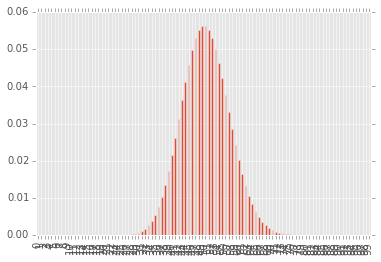

In [12]:
duhseries.plot(kind='bar')

In [13]:
a = np.linspace(0,4,300)
expo = stats.expon

In [14]:
supduh = expo.pdf(a, scale=1/4.)

In [15]:
dumsupduh = pd.Series(supduh, index=a)

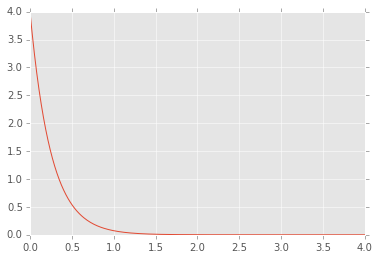

In [16]:
dumsupduh.plot()